In [17]:
import numpy as np
import pickle
import torch
import time

from sklearn.metrics import r2_score, mean_absolute_error, explained_variance_score, mean_squared_error
from sklearn.model_selection import train_test_split
import autosklearn.regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
plt.matplotlib.style.use("https://gist.githubusercontent.com/JonnyCBB/c464d302fefce4722fe6cf5f461114ea/raw/64a78942d3f7b4b5054902f2cee84213eaff872f/matplotlibrc")
cool_colors = ['#00BEFF', '#D4CA3A', '#FF6DAE', '#67E1B5', '#EBACFA', '#9E9E9E', '#F1988E', '#5DB15A', '#E28544', '#52B8AA']
cool_colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']

plt.rcParams.update({'font.size': 14})

In [5]:
X = pickle.load(open('inputs_and_outputs.pkl', 'rb'))['X']
print("shape of X: ", np.shape(X))
y = pickle.load(open('inputs_and_outputs.pkl', 'rb'))['y']
features = pickle.load(open('inputs_and_outputs.pkl', 'rb'))['features'] # feature names
nb_data = np.size(y)
nb_data

shape of X:  (69839, 12)


69839

In [6]:
def diverse_train_test_split(X, train_size):
    ids_train = [np.random.randint(0, nb_data)] # initialize with one random point; pick others in a max diverse fashion
    # select remaining training points
    for j in range(train_size - 1):
        # for each point in data set, compute its min distance to training set
        distances_to_train_set = np.linalg.norm(X - X[ids_train, None, :], axis=2)
        assert np.shape(distances_to_train_set) == (len(ids_train), nb_data)
        min_distances_to_a_training_pt = np.min(distances_to_train_set, axis=0)
        assert np.size(min_distances_to_a_training_pt) == nb_data
        # select point with max min distance to train set (Furthest from train set)
        ids_train.append(np.argmax(min_distances_to_a_training_pt))
    assert np.size(np.unique(ids_train)) == train_size
    ids_test = [i for i in range(nb_data) if not i in ids_train]
    assert np.size(np.unique(ids_test)) == nb_data - train_size
    return np.array(ids_train), np.array(ids_test)

In [4]:
diversify_training = True

In [5]:
def rf_run(nb_training_data, nb_acquire):
    if diversify_training:
        print("\tdiverse RF run")
    else:
        print("\tRF run")
    print("\teval budget", nb_training_data + nb_acquire, "=", nb_training_data, "training data and", nb_acquire, "acquired.")
    # test/train split
    if diversify_training:
        ids_train, ids_test = diverse_train_test_split(X, nb_training_data)
    else:
        ids_train, ids_test = train_test_split(np.arange(nb_data), train_size=nb_training_data)
    
    X_train = X[ids_train, :]
    y_train = y[ids_train]
    
    X_test  = X[ids_test, :]
    
    # train random forest on training data
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)

    # hv random forest make predictions on test data
    y_pred = rf.predict(X_test)

    # rank the test predictions
    ids_test_ranked = np.flip(np.argsort(y_pred))
    
    # acquire the COFs in the test set with highest predicted property
    ids_acquire = ids_test[ids_test_ranked[:nb_acquire]]

    # return the acquired COFs but also the trained COFs which count.
    ids_acquire_incld_training = np.concatenate((ids_acquire, ids_train))
    
    assert np.size(np.unique(ids_acquire_incld_training)) == nb_training_data + nb_acquire
    
    print("\tmax y acquired = ", np.max(y[ids_acquire_incld_training]))
    return ids_acquire_incld_training

In [6]:
rf_res = dict()
rf_res['nb_runs']          = 100
rf_res['nb_evals_budgets'] = [20 * i for i in range(1, 13)] + [250]
print("eval budgets: ", rf_res['nb_evals_budgets'])
rf_res['ids_acquired']     = [[] for b in rf_res['nb_evals_budgets']]
for b in range(len(rf_res['nb_evals_budgets'])):
    nb_evals_budget = rf_res['nb_evals_budgets'][b]
    print("budget for evals:", nb_evals_budget)
    # decide how to spend the evals budget here. say 50/50
    nb_training_data = nb_evals_budget // 2
    nb_acquire = nb_evals_budget // 2
    assert nb_training_data + nb_acquire == nb_evals_budget
    for r in range(rf_res['nb_runs']):
        print("\trun", r)
        ids_acquired = rf_run(nb_training_data, nb_acquire)
        rf_res['ids_acquired'][b].append(ids_acquired)

if not diversify_training:
    with open('rf_results.pkl', 'wb') as file:
        pickle.dump(rf_res, file)
else:
    with open('rf_div_results.pkl', 'wb') as file:
        pickle.dump(rf_res, file)

eval budgets:  [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 250]
budget for evals: 20
	run 0
	diverse RF run
	eval budget 20 = 10 training data and 10 acquired.
	max y acquired =  168.05583815399999
	run 1
	diverse RF run
	eval budget 20 = 10 training data and 10 acquired.
	max y acquired =  175.471266044
	run 2
	diverse RF run
	eval budget 20 = 10 training data and 10 acquired.
	max y acquired =  171.494803798
	run 3
	diverse RF run
	eval budget 20 = 10 training data and 10 acquired.
	max y acquired =  166.6328691
	run 4
	diverse RF run
	eval budget 20 = 10 training data and 10 acquired.
	max y acquired =  172.874325845
	run 5
	diverse RF run
	eval budget 20 = 10 training data and 10 acquired.
	max y acquired =  176.97717943400002
	run 6
	diverse RF run
	eval budget 20 = 10 training data and 10 acquired.
	max y acquired =  171.155147188
	run 7
	diverse RF run
	eval budget 20 = 10 training data and 10 acquired.
	max y acquired =  179.87305674400002
	run 8
	diverse RF run
	e

feature importance

In [50]:
def run_permutation_feature_importance():
    ids_train, ids_test = train_test_split(np.arange(nb_data), train_size=0.8)
    print("# training: ", len(ids_train))
    print("# test: ", len(ids_test))
    
    X_train = X[ids_train, :]
    y_train = y[ids_train]
    
    X_test  = X[ids_test, :]
    y_test  = y[ids_test]
    
    # train random forest on training data
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    
    return permutation_importance(rf, X_test, y_test)

feature_importances = run_permutation_feature_importance()

# training:  55871
# test:  13968


In [51]:
feature_to_label = {feature: feature for feature in features}
feature_to_label[' void fraction [widom]'] = 'void fraction'
feature_to_label[' density [kg/m^3]'] = 'density [kg/m$^3$]'
feature_to_label[' largest included sphere diameter [A]'] = 'diameter of largest\nincluded sphere [$\AA$]'
feature_to_label[' largest free sphere diameter [A]'] = 'diameter of largest\nfree sphere [$\AA$]'
feature_to_label[' surface area [m^2/g]'] = 'surface area [m$^2$/g]'

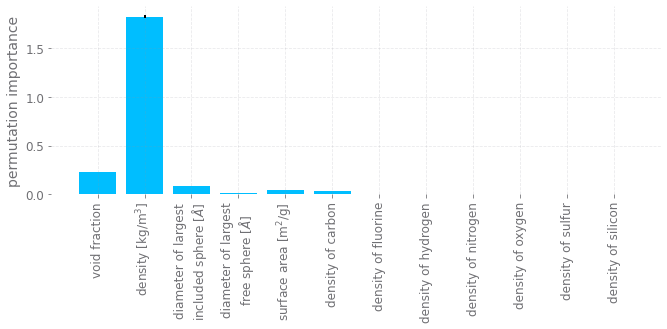

In [56]:
plt.figure(figsize=(6.4 * 1.5, 4.8))
plt.bar([feature_to_label[feature] for feature in features], feature_importances.importances_mean, yerr=feature_importances.importances_std)
plt.xticks(rotation=90)
plt.ylabel("permutation importance")
plt.tight_layout()
plt.savefig("permutation_feature_importance.pdf", format="pdf")

Text(0, 0.5, 'deliverable capacity')

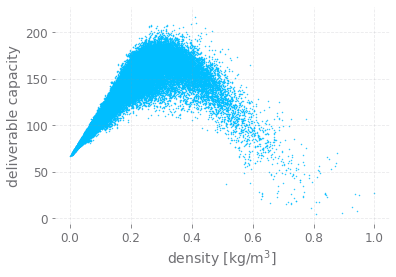

In [67]:
# indeed, density strongly correlated to del cap
plt.figure()
plt.scatter(X[:, 1], y, s= 0.2)
plt.xlabel("density [kg/m$^3$]")
plt.ylabel("deliverable capacity")